In [113]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"

# 데이터 읽기
df = pd.read_csv(url)

In [114]:
print(df)

      age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]


In [117]:
#결측치 확인
missing_values = df.isnull().sum()
print(missing_values)

#X,Y 정의

df = pd.get_dummies(df, drop_first=True)
X = df.drop('charges', axis=1)
y = df['charges']

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

In [121]:
class insurancePriceRegression(nn.Module):
    def __init__(self):
        super(insurancePriceRegression, self).__init__()
        self.fc1 = nn.Linear(8, 64)  
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  
        return x

In [123]:
#Train/Test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


#스케일링
model = insurancePriceRegression()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

In [125]:
# 텐서 변환
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

In [127]:
# 모델 재정의
model = insurancePriceRegression()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [129]:
# 학습 루프
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.0440
Epoch 10, Loss: 0.8038
Epoch 20, Loss: 0.5692
Epoch 30, Loss: 0.3703
Epoch 40, Loss: 0.2718
Epoch 50, Loss: 0.2376
Epoch 60, Loss: 0.2119
Epoch 70, Loss: 0.1937
Epoch 80, Loss: 0.1807
Epoch 90, Loss: 0.1710


In [131]:
model.eval()
with torch.no_grad():
    y_preds = model(X_test_tensor).numpy()
    y_preds = scaler_y.inverse_transform(y_preds)  # 다시 원래 스케일로 되돌리기
    y_test_real = scaler_y.inverse_transform(y_test_tensor.numpy())

In [133]:
from sklearn.metrics import mean_squared_error, r2_score

print("MSE:", mean_squared_error(y_test_real, y_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test_real, y_preds)))
print("R²:", r2_score(y_test_real, y_preds))

MSE: 22199226.0
RMSE: 4711.6055
R²: 0.8570086359977722


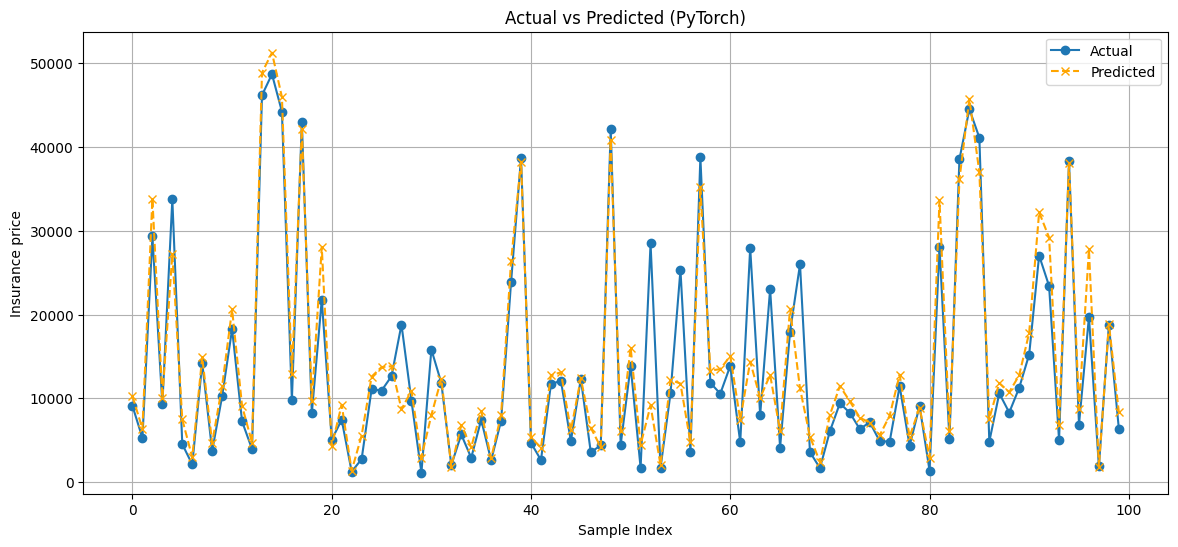

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test_real[:100], label='Actual', marker='o')
plt.plot(y_preds[:100], label='Predicted', marker='x', linestyle='--', color='orange')
plt.title('Actual vs Predicted (PyTorch)')
plt.xlabel('Sample Index')
plt.ylabel('Insurance price')
plt.legend()
plt.grid(True)
plt.show()